In [40]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.linear_model import LinearRegression, SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, cross_val_predict ,GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, recall_score


sns.set()

# "What do we have here?"

In [41]:
titanic = pd.read_csv("train.csv")
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [42]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [43]:
# Pretend we already know for sure that these are unimportant:
unnecessary = ["PassengerId", "Name","SibSp","Parch","Ticket", "Cabin", "Embarked"]
titanic.drop(unnecessary, inplace=True, axis=1)

In [44]:
titanic.isnull().any()

Survived    False
Pclass      False
Sex         False
Age          True
Fare        False
dtype: bool

## Quickly figure out how to fill the missing values

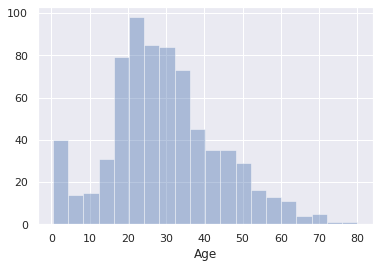

In [45]:
sns.distplot(titanic.Age, norm_hist=False, kde=False)

In [46]:
titanic_filled = titanic.copy()
titanic_filled.Age.fillna(titanic.Age.mean(), inplace=True)

# Create train and dev test sets now to avoid data snooping bias

In [47]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

## Stratify on Pclass column for now. Maybe there is better.

In [48]:
for train_ix, test_ix in split.split(titanic_filled, titanic_filled["Sex"]):
    strat_train = titanic_filled.loc[train_ix]
    strat_devtest = titanic_filled.loc[test_ix]

# What is worth including in the classification?

In [49]:
pd.get_dummies(strat_train).corr()

,Survived,Pclass,Age,Fare,Sex_female,Sex_male
Survived,1.000000,-0.321606,-0.069136,0.256008,0.554241,-0.554241
Pclass,-0.321606,1.000000,-0.346894,-0.550764,-0.119962,0.119962
Age,-0.069136,-0.346894,1.000000,0.088123,-0.093599,0.093599
Fare,0.256008,-0.550764,0.088123,1.000000,0.177242,-0.177242
Sex_female,0.554241,-0.119962,-0.093599,0.177242,1.000000,-1.000000
Sex_male,-0.554241,0.119962,0.093599,-0.177242,-1.000000,1.000000


## --> Include Pclass, Fare and Sex into classification

In [50]:
strat_train.drop(["Age"], inplace=True, axis=1)

# Inspect further

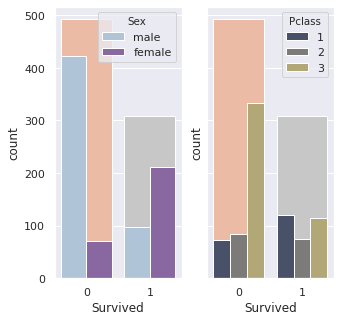

In [51]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize = (5,5))
sns.countplot(x="Survived", data=strat_train, ax = ax[0], palette = "RdGy")
sns.countplot(x="Survived", hue="Sex", data=strat_train, ax = ax[0], palette = "BuPu")
sns.countplot(x="Survived", data=strat_train, ax = ax[1], palette = "RdGy")
sns.countplot(x="Survived", hue="Pclass", data=strat_train, ax = ax[1], palette="cividis")

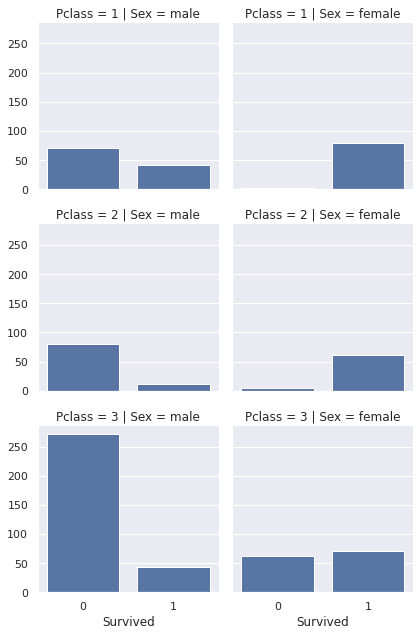

In [52]:
g = sns.FacetGrid(col="Sex", row="Pclass", data=strat_train)
g.map_dataframe(sns.countplot, "Survived")

# Labels

In [53]:
titanic_labels = titanic["Survived"]
strat_train_labels = strat_train["Survived"]
strat_devtest_labels = strat_devtest["Survived"]
strat_train.drop("Survived", inplace=True, axis=1)
strat_devtest.drop("Survived", inplace=True, axis=1)

# Make Pipelines

In [57]:
sex_pip = Pipeline([
    ('one_hot', OneHotEncoder())
])

fare_pip = Pipeline([
    ('fare_std', StandardScaler())
])

attr_pip = ColumnTransformer([
    ("passthrough", "passthrough", ["Pclass"]),
    ("sex", sex_pip, ["Sex"]),
    ("fare", fare_pip, ["Fare"])
], remainder="drop")


lin_reg_pip = Pipeline([
    ("attr_pip", attr_pip),
    ('lin_reg', LinearRegression())
])

log_reg_pip = Pipeline([
    ("attr_pip", attr_pip),
    ('log_reg', LogisticRegression())
])

sgd_clf_pip = Pipeline([
    ("attr_pip", attr_pip),
    ('sgd_clf', SGDClassifier(random_state=42))
])

rndforest_clf_pip = Pipeline([
    ("attr_pip", attr_pip),
    ('rnd_forest', RandomForestClassifier(random_state=42))
])

# Consider Models

## Coarse try

In [59]:
# lin_reg_pip.fit(strat_train, strat_train_labels)
# pred = lin_reg_pip.predict(strat_train)
# accuracy_score(strat_train_labels, pred)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [55]:
log_reg_pip.fit(strat_train, strat_train_labels)
pred = log_reg_pip.predict(strat_train)
accuracy_score(strat_train_labels, pred)

0.7902621722846442

In [60]:
sgd_clf_pip.fit(strat_train, strat_train_labels)
pred = sgd_clf_pip.predict(strat_train)
accuracy_score(strat_train_labels, pred)

0.787765293383271

In [61]:
rndforest_clf_pip.fit(strat_train, strat_train_labels)
pred = rndforest_clf_pip.predict(strat_train)
accuracy_score(strat_train_labels, pred)

0.9076154806491885